In [1]:
#################
# Feb 2026 (last version)
#
# Made for GEOF232/337 (University of Bergen)
#
# Original author: Torunn Sagen
# Current author: Koen van der Heijden, koen.heijden@uib.no

# Read RBR data files: excel

RBR CTD instruments provides data on a ruskin (.rsk) format, which can be converted to several other data formats, like excel or netCDF, in the Ruskin software. 



This Jupyter Notebook gives an example of how to read CTD data from an excel file to a GFPy compatible format. It also shows you how you can add metadata (time & place.



In [12]:
#Import packages
import os
import sys
import numpy as np
import gsw
import matplotlib.pyplot as plt
import pandas as pd
import gsw
from datetime import datetime
# import xarray as xr



In [ ]:
# the location of the data 

datadir = 

metadatadir = 


#### The function below "Read_RBRexcel" can be used to read RBR excel files. 
It identifies the timing of all downcasts (using the excel sheet "Profile annotation"), then uses the time stamps to read the CTD data (from the excel sheet "Data"), which are averaged over 1 m.

In [15]:
def Read_RBRexcel(filepath, figure):    
    """
    Reads excel file with RBR CTD data files, and returns a dictionary with all
    (downcast) CTD data (binned to 1 m) in a dictionary.
        
    Input : 
        filepath - path to the
        figure - show figure (plot of all CTD data & identified downcasts). Yes: 'y'. No: 'n'
        
    Output : 
        ctd_structure - dictionary with all identified downcasts            
    
    """
    # .csv file to pandas DataFrame
    ctd_dataframe = pd.read_excel(filepath,
                                  sheet_name='Data',
                                  skiprows=[0]) 
            
    # All data in the DataFrame
    alltime = [pd.to_datetime(ctd_dataframe['Time'][k]) for k in np.arange(0,len(ctd_dataframe['Time']))] # exact time
    alltime1 = [alltime[j].strftime("%Y-%m-%d %H:%M:%S") for j in np.arange(0, len(alltime))] # time without microseconds
    alldepth = np.array(ctd_dataframe['Depth'])

    # Identify timing of downcasts
    profile_annotation = pd.read_excel(filepath,
                                  sheet_name='Profile annotation',
                                  # engine='openpyxl',
                                  skiprows=[0]) 

    ids = np.where(np.array(profile_annotation['Type']) == 'DOWN')[0]
    sd = np.array(profile_annotation['Time 1'])[ids]
    starts_downcast = [pd.to_datetime(sd[a]).strftime("%Y-%m-%d %H:%M:%S") for a in np.arange(0,len(sd))]
    ed = np.array(profile_annotation['Time 2'])[ids]
    ends_downcast = [pd.to_datetime(ed[a]).strftime("%Y-%m-%d %H:%M:%S") for a in np.arange(0,len(ed))]

    # Find indices of the downcast
    downcasts = np.arange(0,len(starts_downcast))
    start_downcast_ids = []; end_downcast_ids = []
    for k in downcasts:
        start_downcast_ids.append(np.where(np.array(alltime1) == starts_downcast[k])[0][0]) # index of CTD station start
        end_downcast_ids.append(np.where(np.array(alltime1) == ends_downcast[k])[0][0]) # index of CTD station start


    # Check that downcasts have been captured
    if figure == 'y':
        plt.figure(figsize=(8,6))
        plt.plot(alltime, alldepth) # all CTD data
        for k in downcasts: # downcaSTS
            plt.plot(alltime[start_downcast_ids[k]:end_downcast_ids[k]], alldepth[start_downcast_ids[k]:end_downcast_ids[k]])
        plt.gca().invert_yaxis()
        plt.xlabel('Time')
        plt.ylabel('Depth')
        plt.grid()

    
    # Make dictionary with CTD data from downcast
    ctd_structure = {}
    
    for k in downcasts: # number of stations
        ctd_downcast = ctd_dataframe[start_downcast_ids[k]:end_downcast_ids[k]] # dataframe with relevant ctd data from downcast
        ctd_downcast_new = {} # store binned values in this dictionary
        
        names = np.array(ctd_downcast.columns)
        #new_names = ['c', 't', 'o2 (umol/l)', 'p']
        #var_toloop = [1,2,6,7,8,9]
        
        # Binning to every 1 m by using median (values from +-0.5 m)
        allz = np.around(np.array(ctd_downcast['Depth']), decimals=1)
        z_ideal = np.unique(np.around(allz, decimals=0))
        
        for j in np.arange(1, len(ctd_downcast.columns)): # for each variable in ctd down cast
            var = np.array(ctd_downcast[names[j]])
            var_new = []    
        
            for i in z_ideal[1:]: # for each depth
                ids = np.where((allz >= int(i)-0.5) & (allz < int(i)+0.5))[0] # find depth data
                var_new.append(np.mean(var[ids])) # find mean of the variable withing +- 1 m
            ctd_downcast_new[names[j]] = np.array(var_new)
        
        # round depth to closest m
        ctd_downcast_new['Depth'] = np.round(ctd_downcast_new['Depth'])
        
        # add info about time to the structure
        ctd_downcast_new['Time'] = alltime[start_downcast_ids[k]]
    
        ctd_structure[downcasts[k]] = ctd_downcast_new

    return ctd_structure

#### The example below uses an excel file from the cruise HB2024009016.

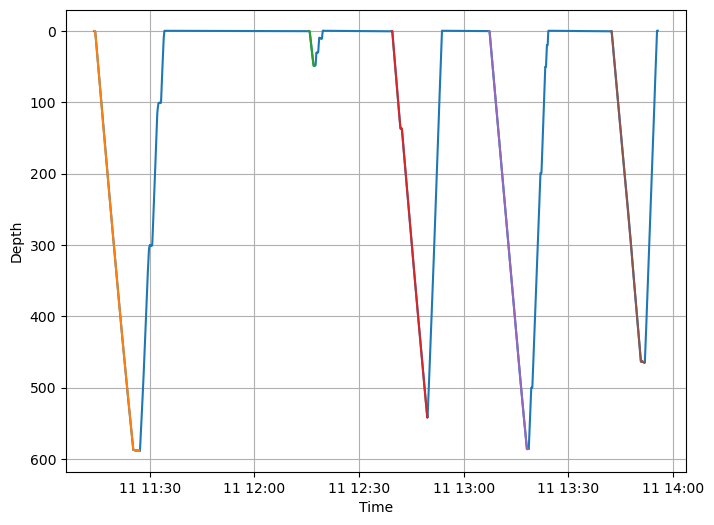

In [16]:
# Add filepath to the data
filepath = datadir # Path to data from March 5th

# Use the function to read the data
CTD_struct = Read_RBRexcel(filepath, figure='y')


# figure = 'y: plot figure showing all downcasts in the excel file

In [17]:
# Each key in the dictionary refers to each profile/downcast

CTD_struct.keys() 


dict_keys([np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)])

In [18]:
# And for each key, you can look at the parameters availale from the downcast.

CTD_struct[0].keys()

# NB!! Note that "Pressure" and "Sea pressure" are parameters available, so make sure to use the correct one!

dict_keys(['Conductivity', 'Temperature', 'Pressure', 'Chlorophyll', 'Temperature.1', 'Dissolved O2 concentration', 'PAR', 'Sea pressure', 'Depth', 'Salinity', 'Speed of sound', 'Specific conductivity', 'Dissolved O2 saturation', 'Density anomaly', 'Time'])

Now that the downcasts have been identified and stored in the "CTD_struct"- dictonary, you can now plot vertical profiles 

#### Plot different variables for one station

Text(0.5, 0, 'Dissolved oxygen consentration [umol/L]')

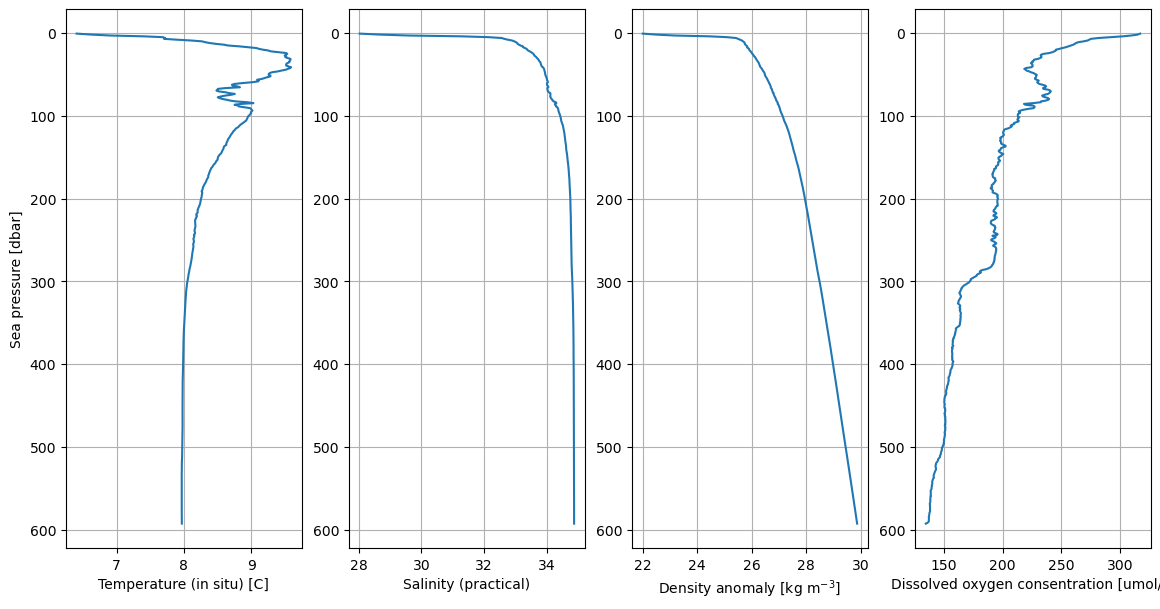

In [19]:
station_id = 0 # choose which downcast you want to plot

plt.figure(figsize=(14,7))
plt.subplot(1,4,1)
plt.plot(CTD_struct[station_id]['Temperature'], CTD_struct[station_id]['Sea pressure'])
#plt.plot(CTD_struct[station_id]['Temperature.1'], CTD_struct[station_id]['Sea pressure'])
plt.gca().invert_yaxis()
plt.grid()
plt.ylabel('Sea pressure [dbar]')
plt.xlabel('Temperature (in situ) [C]')

plt.subplot(1,4,2)
plt.plot(CTD_struct[station_id]['Salinity'], CTD_struct[station_id]['Sea pressure'])
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('Salinity (practical)')

plt.subplot(1,4,3)
plt.plot(CTD_struct[station_id]['Density anomaly'], CTD_struct[station_id]['Sea pressure'])
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('Density anomaly [kg m$^{-3}$]')

plt.subplot(1,4,4)
plt.plot(CTD_struct[station_id]['Dissolved O2 concentration'], CTD_struct[station_id]['Sea pressure'])
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('Dissolved oxygen consentration [umol/L]')

#### Add metadata

The RBR data does NOT contain information about the location of the data. This has to be added to the data manually.
It is therefore very important to take notes during the cruise of when and where you do CTD measurements!

In [ ]:
# Example of how to add metadata to the dictionary.
dats = pd.read_excel(metadatadir,
                     sheet_name=0,
                     engine='openpyxl',
                     header=1)

# Find all station numbers from first day, March 11th
day = np.where(np.array(dats['Day'])==11)[0]

#Date
y=np.array(dats['Year'][day])
mo=np.array(dats['Month'])[day]
d=np.array(dats['Day'])[day]
h=np.array(dats['Hour'])[day]
mi=np.array(dats['Min'])[day]
dates = [datetime(int(y[i]), int(mo[i]), int(d[i]), int(h[i]), int(mi[i])) for i in np.arange(0,len(day))]


# Position
latd = np.array(dats['LatDEG'][day])
latm = np.array(dats['LatMIN'][day])
lond = np.array(dats['LonDEG'][day])
lonm = np.array(dats['LonMIN'][day])

lats = [latd[i] + latm[i]/60 for i in np.arange(0,len(day))]
lons = [lond[i] + lonm[i]/60 for i in np.arange(0,len(day))]


# Station number
sta = np.array(dats['Station'])[day]

print(sta)
print(dates)
#print(lats)
#print(lons)


[237 243 240 '236A' 221]
[datetime.datetime(2024, 3, 11, 11, 10), datetime.datetime(2024, 3, 11, 12, 15), datetime.datetime(2024, 3, 11, 12, 40), datetime.datetime(2024, 3, 11, 13, 10), datetime.datetime(2024, 3, 11, 13, 40)]


#### Make the data GFPy compatible

When the meta data is added to the dictionary, you can convert the dictionary to a format that is compatible with the GFPy package. This means that you now can use the function from the GFPy package with the data you have imported from the excel & metadata file

In [22]:
# CTD time from each cast
ctd_times = np.array([CTD_struct[i]['Time'] for i in np.arange(0,len(CTD_struct))])

CTD_GFPy = {} # Dictionary to store CTD data from each station

for st in np.arange(0,len(dates)):
    # Find the CTD data closest in time to the meta data
    td = ctd_times - dates[st] 
    tds = [td[k].total_seconds() for k in np.arange(0, len(td))]
    id_sta = np.where(np.abs(tds) == np.nanmin(np.abs(tds)))[0][0]

    # Get CTD data    
    CTD_dict = CTD_struct[id_sta]
    p = CTD_dict['Sea pressure']
    sp = CTD_dict['Salinity']
    t = CTD_dict['Temperature']
    sigma = CTD_dict['Density anomaly']
    
    # Calculate data
    sa = gsw.SA_from_SP( sp,p, lons[st], lats[st])
    ct = gsw.CT_from_t(sa,t,p)
    sigth = gsw.sigma0(sa,ct)    
    
    # Create new dict with information about the 
    ctd_togfpy = {}
    ctd_togfpy['LAT'] = lats[st]
    ctd_togfpy['LON'] = lons[st]
    ctd_togfpy['z'] = CTD_dict['Depth']
    ctd_togfpy['BottomDepth'] = np.round(np.nanmax(CTD_dict['Depth'])+10)
    ctd_togfpy['p'] = p
    ctd_togfpy['C'] = CTD_dict['Conductivity']
    ctd_togfpy['SP'] = sp
    ctd_togfpy['T'] = t
    ctd_togfpy['Sigma'] = sigma
    ctd_togfpy['OX raw'] = CTD_dict['Dissolved O2 concentration']+1000
    ctd_togfpy['OX raw unit'] = 'umol/L + 1000'
    ctd_togfpy['Note'] = 'Salinity and oxygen has not been calibrated'
    
    # Calculations
    ctd_togfpy['SA'] = sa
    ctd_togfpy['CT'] = ct
    ctd_togfpy['SIGTH'] = sigth
    ctd_togfpy['st'] = sta[st]
    
    CTD_GFPy[sta[st]] = ctd_togfpy




In [26]:
CTD_GFPy[237]

{'LAT': np.float64(60.620666666666665),
 'LON': np.float64(5.542666666666666),
 'z': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
         34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
         45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
         56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
         67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
         78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
         89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
        100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
        111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
        122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
        133., 134., 135., 13

#### Save this GFPy-compatible structure as ```CTD_205914_20240311_1533.npy```

In [23]:
np.save(r"Processed_Data\CTD_205914_20240311_1533.npy", arr = CTD_GFPy)